In [118]:
# Imports
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

#visual
import seaborn as sns 
import matplotlib.pyplot as plt
import missingno as mno
from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

#learning
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, f1_score, recall_score
from sklearn.utils.multiclass import unique_labels
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Activation
from sklearn import metrics

# import warnings filter
from warnings import simplefilter

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Data

In [119]:
# Naming the columns
names = ['account_status', 'duration', 'credit_history',
             'purpose', 'credit_amount', 'savings_account', 'employment_since',
             'installment_rate', 'personal_status_sex', 'guarantors', 
             'residence_since', 'property', 'age', 'other_installment_plans',
             'housing', 'number_of_credits', 'job', 'people_to_maintain',
             'phone', 'foreign_worker', 'creditworthy']

df = pd.read_csv('kredit.dat', header=None, sep="\t", names=names)
df.shape

(1000, 21)

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   account_status           1000 non-null   object
 1   duration                 1000 non-null   int64 
 2   credit_history           1000 non-null   object
 3   purpose                  1000 non-null   object
 4   credit_amount            1000 non-null   int64 
 5   savings_account          1000 non-null   object
 6   employment_since         1000 non-null   object
 7   installment_rate         1000 non-null   int64 
 8   personal_status_sex      1000 non-null   object
 9   guarantors               1000 non-null   object
 10  residence_since          1000 non-null   int64 
 11  property                 1000 non-null   object
 12  age                      1000 non-null   int64 
 13  other_installment_plans  1000 non-null   object
 14  housing                  1000 non-null   

In [121]:
# Select the Last column - target variable
df.creditworthy.replace([1,2], [1,0], inplace=True)
label = df['creditworthy']
df_new = df.drop(columns=['creditworthy'])
df_new.shape

(1000, 20)

In [122]:
print(f'Number of data points: {df_new.shape[0]}')
print(f'Number of Attributes: {df_new.shape[1]}')
df_new.head(10)

Number of data points: 1000
Number of Attributes: 20


,account_status,duration,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,personal_status_sex,guarantors,residence_since,property,age,other_installment_plans,housing,number_of_credits,job,people_to_maintain,phone,foreign_worker
0,A14,36,A32,?,2299,A63,?,4,A93,A101,4,A123,39,A143,A152,1,A173,1,A191,?
1,A12,18,A32,A46,1239,A65,A73,4,A93,A101,4,A124,61,A143,A153,1,?,1,A191,A201
2,A13,24,A32,A40,947,A61,A74,4,A93,A101,3,A124,38,A141,A153,1,?,2,A191,?
3,A14,15,A33,A43,1478,A61,A73,4,A94,A101,3,A121,33,A141,A152,2,A173,1,A191,A201
4,A14,24,A32,A40,1525,A64,A74,4,A92,A101,3,A123,34,A143,A152,1,A173,2,A192,A201
5,A12,24,A34,A40,3878,A62,?,4,A91,A101,2,A123,37,A143,A152,1,?,1,A192,A201
6,A14,24,A32,A41,6313,A65,A75,3,A93,A101,4,A123,41,A143,A152,1,A174,2,A192,A201
7,A11,21,A33,A46,3414,A61,?,2,A93,A101,1,A122,26,A143,A152,2,A173,1,A191,A201
8,A11,24,A34,A41,6419,A61,?,2,A92,A101,4,A124,44,A143,A153,2,A174,2,A192,A201
9,A12,18,A32,?,1924,A65,A72,4,A92,A101,3,A121,27,A143,A151,1,A173,1,A191,?


In [123]:
#Change the 'phone' and 'foreign_worker' coloum values into numeric one
#Telephone: A191: none; A192: yes, registered under the customers name
#Foreign worker: A201: yes; A202: no

df_new.replace('A201', 1, inplace=True)
df_new.replace('A202', 0, inplace=True)
df_new.replace('A191', 0, inplace=True)
df_new.replace('A192', 1, inplace=True)

# Handle Missing Values

In [124]:
# For more convenient operations for missing values, replace ? with NaN
# As there are too many missing values to remove these points from the dataset
df_new.replace("?", np.nan, inplace=True)

In [125]:
print(f'Number of Missing Values:\n\n{df_new.isnull().sum()}')

Number of Missing Values:

account_status               0
duration                     0
credit_history               0
purpose                    173
credit_amount                0
savings_account              0
employment_since           496
installment_rate             0
personal_status_sex          0
guarantors                   0
residence_since              0
property                     0
age                          0
other_installment_plans      0
housing                      0
number_of_credits            0
job                        232
people_to_maintain           0
phone                        0
foreign_worker             360
dtype: int64


In [126]:
print(f'Without omiting the missing values columns {df_new.shape}')

# Collect the missing columns
missing_columns = ['purpose', 'employment_since', 'job', 'foreign_worker']

# create df with features that are fully available; delete the column with contains Null values
df_new = df_new.dropna(axis=1, how='any')

print(f'Omiting the missing values columns {df_new.shape}')

Without omiting the missing values columns (1000, 20)
Omiting the missing values columns (1000, 16)


In [127]:
# Percentage of missing values
df[missing_columns].isnull().sum()/len(df) * 100

purpose             0.0
employment_since    0.0
job                 0.0
foreign_worker      0.0
dtype: float64

In [128]:
print(f'Number of Missing Values:\n\n{df_new.isnull().sum()}')

Number of Missing Values:

account_status             0
duration                   0
credit_history             0
credit_amount              0
savings_account            0
installment_rate           0
personal_status_sex        0
guarantors                 0
residence_since            0
property                   0
age                        0
other_installment_plans    0
housing                    0
number_of_credits          0
people_to_maintain         0
phone                      0
dtype: int64


# Visualize data

In [129]:
df['installment_rate'].value_counts(ascending=True)

1    136
3    157
2    231
4    476
Name: installment_rate, dtype: int64

[[<AxesSubplot:title={'center':'duration'}>
  <AxesSubplot:title={'center':'credit_amount'}>
  <AxesSubplot:title={'center':'installment_rate'}>]
 [<AxesSubplot:title={'center':'residence_since'}>
  <AxesSubplot:title={'center':'age'}>
  <AxesSubplot:title={'center':'number_of_credits'}>]
 [<AxesSubplot:title={'center':'people_to_maintain'}>
  <AxesSubplot:title={'center':'creditworthy'}> <AxesSubplot:>]]


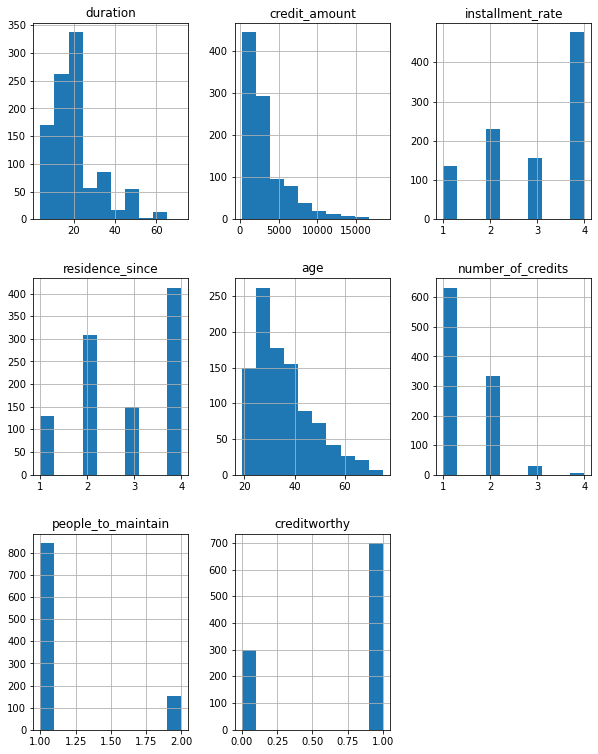

In [130]:
print(df.hist(figsize = (10,13)))

A93    548
A92    310
A94     92
A91     50
Name: personal_status_sex, dtype: int64


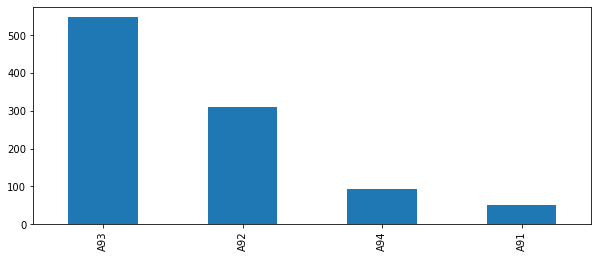

In [131]:
print(df['personal_status_sex'].value_counts())

fig, ax = plt.subplots(figsize=(10,4))
df['personal_status_sex'].value_counts().plot(kind='bar')
plt.show()
# A91: male: divorced/separated A92: female: divorced/separated/married
# A93: male: single # A94: male: married/widowed

In [132]:
df.groupby(['residence_since'])['creditworthy'].value_counts()

residence_since  creditworthy
1                1                94
                 0                36
2                1               211
                 0                97
3                1               106
                 0                43
4                1               289
                 0               124
Name: creditworthy, dtype: int64

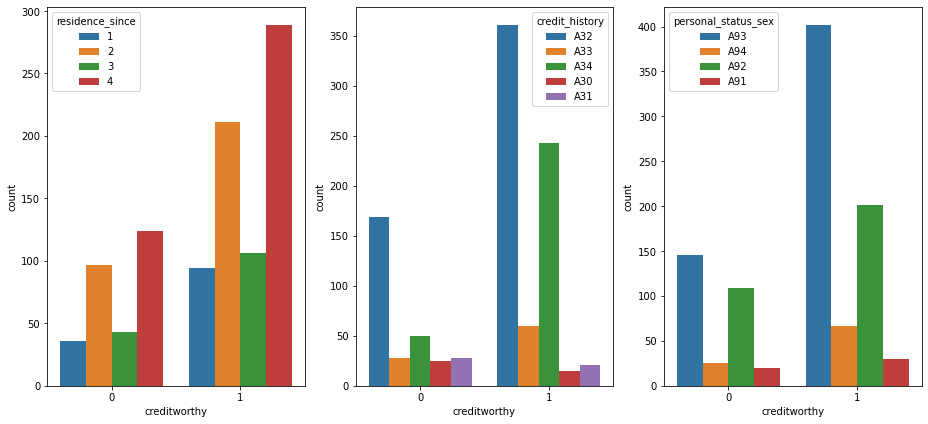

In [133]:
_, axes = plt.subplots(1, 3, figsize=(13,6))

sns.countplot(x='creditworthy', hue='residence_since', data=df, ax=axes[0]);
sns.countplot(x='creditworthy', hue='credit_history', data=df, ax=axes[1]);
sns.countplot(x='creditworthy', hue='personal_status_sex', data=df, ax=axes[2]);
plt.tight_layout()

# Categorical

In [134]:
def categorical_numerical_split(df):
    categorical = [att for att in df.columns if df[att].dtype == 'object']
    numerical = [att for att in df.columns if df[att].dtype == 'int64']
    return categorical, numerical

categorical, numerical = categorical_numerical_split(df)

print(f'Categorical features:\n{categorical}\n')
print(f'Numerical features:\n{numerical}')

Categorical features:
['account_status', 'credit_history', 'purpose', 'savings_account', 'employment_since', 'personal_status_sex', 'guarantors', 'property', 'other_installment_plans', 'housing', 'job', 'phone', 'foreign_worker']

Numerical features:
['duration', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'number_of_credits', 'people_to_maintain', 'creditworthy']


In [135]:
# return number of unique elements in the object

df[categorical].nunique()

account_status              4
credit_history              5
purpose                    11
savings_account             5
employment_since            6
personal_status_sex         4
guarantors                  3
property                    4
other_installment_plans     3
housing                     3
job                         5
phone                       2
foreign_worker              3
dtype: int64

In [136]:
# Feature representation

print("Unique categorical values:")
for att in df.select_dtypes(include=[object]):
    print(att,":", df[att].unique())

Unique categorical values:
account_status : ['A14' 'A12' 'A13' 'A11']
credit_history : ['A32' 'A33' 'A34' 'A30' 'A31']
purpose : ['?' 'A46' 'A40' 'A43' 'A41' 'A42' 'A49' 'A410' 'A45' 'A48' 'A44']
savings_account : ['A63' 'A65' 'A61' 'A64' 'A62']
employment_since : ['?' 'A73' 'A74' 'A75' 'A72' 'A71']
personal_status_sex : ['A93' 'A94' 'A92' 'A91']
guarantors : ['A101' 'A102' 'A103']
property : ['A123' 'A124' 'A121' 'A122']
other_installment_plans : ['A143' 'A141' 'A142']
housing : ['A152' 'A153' 'A151']
job : ['A173' '?' 'A174' 'A172' 'A171']
phone : ['A191' 'A192']
foreign_worker : ['?' 'A201' 'A202']


<b><h2>Encodes nominal features to numeric features</h2></b>

Many machine learning algorithms cannot operate on label data directly. They require all input variables and output variables to be numeric.<br>

return: data frame with all-numeric features

In [137]:
def str_to_num(df):
    # create a new df with categorical features only, encoded as numbers
    categorical, numerical = categorical_numerical_split(df)
    
    enc = LabelEncoder()
    df_encoded = df[categorical].apply(lambda x: enc.fit_transform(x))

    df_encoded_concat = pd.concat([df_encoded, df[numerical]], axis=1)
    
    # Create a dict to decode numeric values; returns a dictionary-like object
    d = defaultdict()
    
    for col_name in df[categorical]:
        # e.g.: account_status_A14 :  3
        for unique_str_val, unique_num_val in zip(df[col_name].unique(), df_encoded[col_name].unique()):
                d[col_name + '_' + unique_str_val] = unique_num_val            
    
    return df_encoded_concat , d

In [138]:
df_new_enc, df_new_enc_dict = str_to_num(df_new)

# Print out new numericaly encoded features
for k,v in df_new_enc_dict.items():
    print(k, ': ', v)

account_status_A14 :  3
account_status_A12 :  1
account_status_A13 :  2
account_status_A11 :  0
credit_history_A32 :  2
credit_history_A33 :  3
credit_history_A34 :  4
credit_history_A30 :  0
credit_history_A31 :  1
savings_account_A63 :  2
savings_account_A65 :  4
savings_account_A61 :  0
savings_account_A64 :  3
savings_account_A62 :  1
personal_status_sex_A93 :  2
personal_status_sex_A94 :  3
personal_status_sex_A92 :  1
personal_status_sex_A91 :  0
guarantors_A101 :  0
guarantors_A102 :  1
guarantors_A103 :  2
property_A123 :  2
property_A124 :  3
property_A121 :  0
property_A122 :  1
other_installment_plans_A143 :  2
other_installment_plans_A141 :  0
other_installment_plans_A142 :  1
housing_A152 :  1
housing_A153 :  2
housing_A151 :  0


In [139]:
# Make sure there are still 16 feature
print(df_new_enc.shape)

(1000, 16)


For categorical variables where no such ordinal relationship exists, a one-hot encoding can be applied to the integer representation. 

<b> One-Hot Encoding: </b> The integer encoded variable is removed and a new binary variable is added for each unique integer value.

<b>df:</b> dataframe

<b>to_one_hot:</b> list of columns to encode 

<b>return:</b> encoded df

In [140]:
def to_one_hot(df, verbose=False):
    categorical, numerical = categorical_numerical_split(df)
    
    # 1-hot encoding for the categorical variables
    df_only_one_hot = pd.get_dummies(df[categorical])
    
    if verbose == True:
        print(f'new 1-hot-encoded variables:\n {list(df_only_one_hot.columns)}')
    
    # Concatenate numerical and categorical data
    df_new_onehot = pd.concat([df[numerical], df_only_one_hot], axis = 1)
    
    if verbose == True:
        print(f'Shape: {df_new_onehot.shape}')
        df_new_onehot.head()
    
    return df_new_onehot

In [141]:
# Fatures that shoud be encoded for X_train
df_new_onehot = to_one_hot(df_new, verbose=True)

new 1-hot-encoded variables:
 ['account_status_A11', 'account_status_A12', 'account_status_A13', 'account_status_A14', 'credit_history_A30', 'credit_history_A31', 'credit_history_A32', 'credit_history_A33', 'credit_history_A34', 'savings_account_A61', 'savings_account_A62', 'savings_account_A63', 'savings_account_A64', 'savings_account_A65', 'personal_status_sex_A91', 'personal_status_sex_A92', 'personal_status_sex_A93', 'personal_status_sex_A94', 'guarantors_A101', 'guarantors_A102', 'guarantors_A103', 'property_A121', 'property_A122', 'property_A123', 'property_A124', 'other_installment_plans_A141', 'other_installment_plans_A142', 'other_installment_plans_A143', 'housing_A151', 'housing_A152', 'housing_A153']
Shape: (1000, 39)


In [142]:
df_new_onehot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   duration                      1000 non-null   int64
 1   credit_amount                 1000 non-null   int64
 2   installment_rate              1000 non-null   int64
 3   residence_since               1000 non-null   int64
 4   age                           1000 non-null   int64
 5   number_of_credits             1000 non-null   int64
 6   people_to_maintain            1000 non-null   int64
 7   phone                         1000 non-null   int64
 8   account_status_A11            1000 non-null   uint8
 9   account_status_A12            1000 non-null   uint8
 10  account_status_A13            1000 non-null   uint8
 11  account_status_A14            1000 non-null   uint8
 12  credit_history_A30            1000 non-null   uint8
 13  credit_history_A31            1000

# Check the balanced of the dataset

1    700
0    300
Name: creditworthy, dtype: int64


<AxesSubplot:>

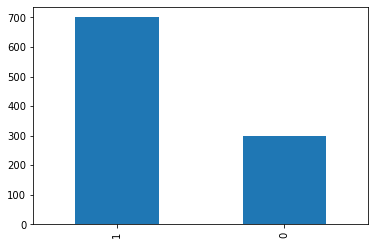

In [143]:
print(label.value_counts())

label.value_counts().plot(kind='bar', label= 'Target Values')

1 = good, trustworthy

0 = bad, Not trustworthy

There are more than twice as many creditworthy examples

A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary. One way to solve this problem is to oversample the examples in the minority class.

The most common technique is called <b>SMOTE (Synthetic Minority Over-sampling Technique).</b>
In simple terms, it looks at the feature space for the minority class data points
and considers its k nearest neighbours.

In [144]:
def balance_data(df,label):
    sm = SMOTE(random_state=7)

    # Fit the model to generate the data.
    cols = df.columns
    df, label = sm.fit_resample(df, label)
    df = pd.DataFrame(df)
    label = pd.Series(label)

    df.columns = cols
    return df,label

0    700
1    700
Name: creditworthy, dtype: int64


<AxesSubplot:>

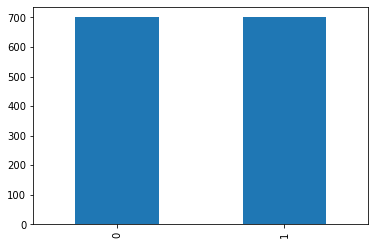

In [145]:
label_orig = label
df_new_enc, label_enc = balance_data(df_new_enc,label_orig)
df_new_onehot, label_onehot = balance_data(df_new_onehot, label_orig)

print(label_enc.value_counts())

label_enc.value_counts().plot(kind='bar', label= 'Target Values')

1 = good, trustworthy

0 = bad, Not trustworthy

In [150]:
df_new_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   account_status           1400 non-null   int32
 1   credit_history           1400 non-null   int32
 2   savings_account          1400 non-null   int32
 3   personal_status_sex      1400 non-null   int32
 4   guarantors               1400 non-null   int32
 5   property                 1400 non-null   int32
 6   other_installment_plans  1400 non-null   int32
 7   housing                  1400 non-null   int32
 8   duration                 1400 non-null   int64
 9   credit_amount            1400 non-null   int64
 10  installment_rate         1400 non-null   int64
 11  residence_since          1400 non-null   int64
 12  age                      1400 non-null   int64
 13  number_of_credits        1400 non-null   int64
 14  people_to_maintain       1400 non-null   int64
 15  phon

(1400, 39)


<AxesSubplot:>

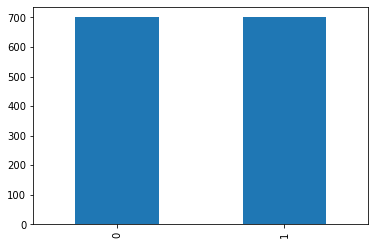

In [151]:
print(df_new_onehot.shape)

label_onehot.value_counts().plot(kind='bar', label= 'Target Values')

1 = good, trustworthy

0 = bad, Not trustworthy

# Evaluation Functions

In [152]:
#10-fold Cross Validation on training and validation data
def cross_validate(clf, X_train, y_train, metrics=['precision', 'accuracy']):
    for metric in metrics: 
        scores = cross_val_score(clf, X_train, y_train, cv=10, scoring=metric)
        
        # The mean score and standard deviation of the score estimate
        print("Cross Validation %s: %0.2f (+/- %0.2f)" % (
            metric, scores.mean(), scores.std()))
    
    return 

#Fits classifier
def train(clf, X_train, y_train):
    print(f'Training a {clf.__class__.__name__}')
    print(f'with a training set size of {len(X_train)}')
    clf.fit(X_train, y_train)
    return clf

#Predict on unseen test data
def predict(clf, X_test):    
    y_pred = clf.predict(X_test)
    return y_pred


#Evaluate on Precision and Accuracy
def evaluate_test(y_test, y_pred):
    print(f'Test Precision Score: {precision_score(y_test, y_pred)}')
    print(f'Test Recall Score: {recall_score(y_test, y_pred)}')
    print(f'Test Accuracy Score: {accuracy_score(y_test, y_pred)}')   
    print(f'Test F1-score Score: {f1_score(y_test, y_pred)}')
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f'Test Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}')
    print(f'Number of False Positives: {fp}')
    
    return 

def train_predict(clf, X_train, y_train, X_test, y_test=None):
    # Train the classifier
    clf = train(clf, X_train, y_train)
    
    # Predict labes
    y_pred = predict(clf, X_test)
    
    return y_pred

# Random Forest

In [176]:
df_news = [df_new_enc, df_new_onehot]
labels = [label_enc, label_onehot]
names = ['Numerically Encoded Features: ', 'One-hot Encoded Features']

for df_new_encoded, lab, name in zip(df_news, labels, names):
    print('\n',name)
    print(df_new_encoded.shape)
    
    # Spliting X and y into train and test version
    X_train, X_test, y_train, y_test = train_test_split(df_new_encoded, lab, test_size = 0.25, random_state=4)

    clf = RandomForestClassifier(n_estimators=100, random_state=33)
    y_pred = train_predict(clf, X_train, y_train, X_test, y_test)
    evaluate_test(y_test, y_pred)


 Numerically Encoded Features: 
(1400, 16)
Training a RandomForestClassifier
with a training set size of 1050
Test Precision Score: 0.8268156424581006
Test Recall Score: 0.8176795580110497
Test Accuracy Score: 0.8171428571428572
Test F1-score Score: 0.8222222222222223
Test Confusion Matrix: 
 [[138  31]
 [ 33 148]]
Number of False Positives: 31

 One-hot Encoded Features
(1400, 39)
Training a RandomForestClassifier
with a training set size of 1050
Test Precision Score: 0.8369565217391305
Test Recall Score: 0.850828729281768
Test Accuracy Score: 0.8371428571428572
Test F1-score Score: 0.8438356164383561
Test Confusion Matrix: 
 [[139  30]
 [ 27 154]]
Number of False Positives: 30


In [177]:
X_train, X_test, y_train, y_test = train_test_split(df_new_enc, label_enc, test_size = 0.25)

train_accuracies = []
test_accuracies = []

for i in range(1,50):
    clf = RandomForestClassifier(n_estimators=i, max_depth=i)
    clf.fit(X_train, y_train)
    score_train = clf.score(X_train,y_train)
    score_test = clf.score(X_test,y_test)
    train_accuracies.append(score_train)
    test_accuracies.append(score_test)

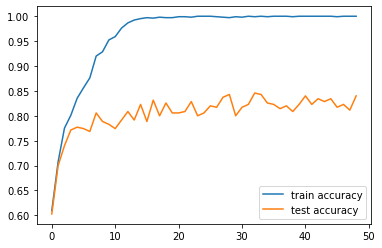

In [178]:
plt.plot(train_accuracies, label='train accuracy')
plt.plot(test_accuracies, label='test accuracy')
plt.legend()
plt.show()

In [179]:
X_train, X_test, y_train, y_test = train_test_split(df_new_onehot, label_onehot, test_size = 0.25)

train_accuracies = []
test_accuracies = []

for i in range(1,50):
    clf = RandomForestClassifier(n_estimators=i, max_depth=i)
    clf.fit(X_train, y_train)
    score_train = clf.score(X_train,y_train)
    score_test = clf.score(X_test,y_test)
    train_accuracies.append(score_train)
    test_accuracies.append(score_test)

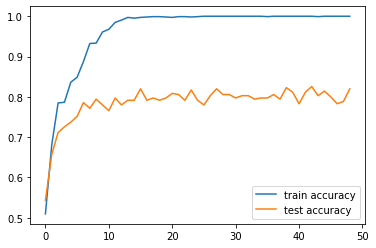

In [180]:
plt.plot(train_accuracies, label='train accuracy')
plt.plot(test_accuracies, label='test accuracy')
plt.legend()
plt.show()

# Visualize the most important features

In [181]:
def display_feature_importance(trained_clf):

    # Print the name and gini importance of each feature
    importances = trained_clf.feature_importances_
    print(f'\n Feature Importance, sums up to 1:')
    for feature in zip(X_train.columns, importances):
        print(feature)
        
    # Visualise Feature Importance:
    indices = np.argsort(trained_clf.feature_importances_)
    plt.figure(figsize=(10,8))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='g', align='center')
    plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
    return 

Training a RandomForestClassifier
with a training set size of 1050

 Feature Importance, sums up to 1:
('account_status', 0.21287874434204954)
('credit_history', 0.07733985591890731)
('savings_account', 0.06317250525301006)
('personal_status_sex', 0.04187562190370147)
('guarantors', 0.02624280530490451)
('property', 0.04142113594019177)
('other_installment_plans', 0.033489995256158825)
('housing', 0.030313486399226944)
('duration', 0.10752014184391492)
('credit_amount', 0.12502535231406792)
('installment_rate', 0.04034862388427357)
('residence_since', 0.04920635487375426)
('age', 0.09320634885892498)
('number_of_credits', 0.01804513686612274)
('people_to_maintain', 0.013027761645051206)
('phone', 0.026886129395740137)


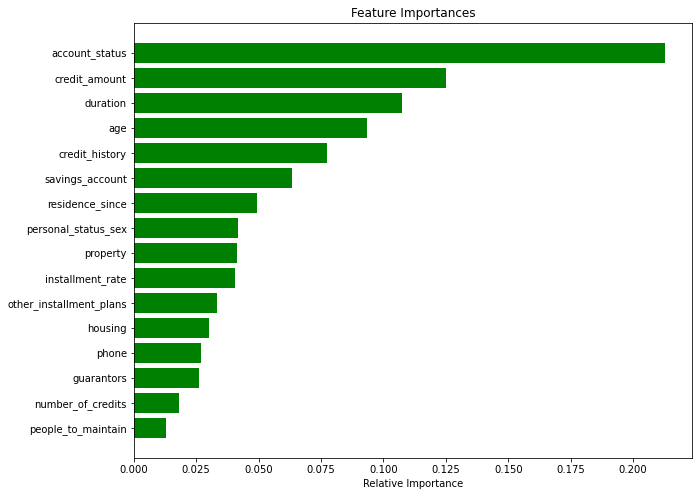

In [182]:
X_train, X_test, y_train, y_test = train_test_split(df_new_enc, label_enc, test_size = 0.25)

clf_enc = RandomForestClassifier()
y_pred = train_predict(clf_enc, X_train, y_train, X_test, y_test)
display_feature_importance(clf_enc)

Training a RandomForestClassifier
with a training set size of 1050

 Feature Importance, sums up to 1:
('duration', 0.08401373676151505)
('credit_amount', 0.09149147225589295)
('installment_rate', 0.03394643527602554)
('residence_since', 0.03861136530696107)
('age', 0.07614848819431645)
('number_of_credits', 0.018712632023602484)
('people_to_maintain', 0.009968492445602361)
('phone', 0.02275045033768654)
('account_status_A11', 0.01665743875326212)
('account_status_A12', 0.01954926803684743)
('account_status_A13', 0.015016493377592139)
('account_status_A14', 0.13446771294579618)
('credit_history_A30', 0.004803019606757944)
('credit_history_A31', 0.005945860622582673)
('credit_history_A32', 0.020239534838966178)
('credit_history_A33', 0.016890524475014726)
('credit_history_A34', 0.04083174085303399)
('savings_account_A61', 0.01755853658732588)
('savings_account_A62', 0.011015546572907969)
('savings_account_A63', 0.009681288806764715)
('savings_account_A64', 0.006122433079794079)
('saving

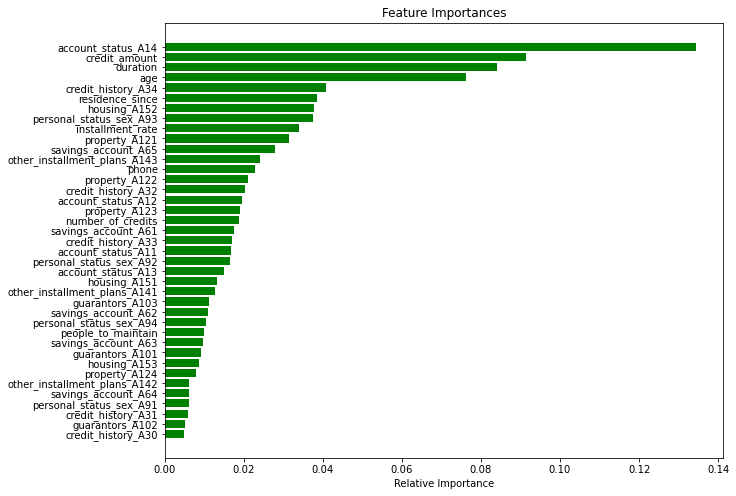

In [183]:
X_train, X_test, y_train, y_test = train_test_split(df_new_onehot, label_onehot, test_size = 0.25)

clf_onehot = RandomForestClassifier()
y_pred = train_predict(clf_onehot, X_train, y_train, X_test, y_test)
display_feature_importance(clf_onehot)

# Correlation Matrix between features

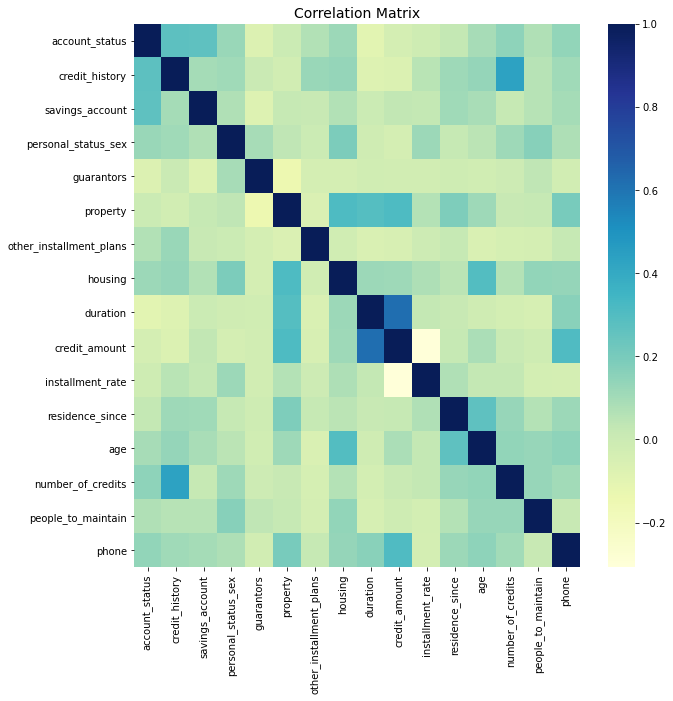

In [185]:
def plot_corr_matrix(df):
    # Sample figsize in inches
    fig, ax = plt.subplots(figsize=(10,10))         
    # Imbalanced DataFrame Correlation
    corr = df.corr()
    sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
    ax.set_title("Correlation Matrix", fontsize=14)
    plt.show()
    return

plot_corr_matrix(df_new_enc)

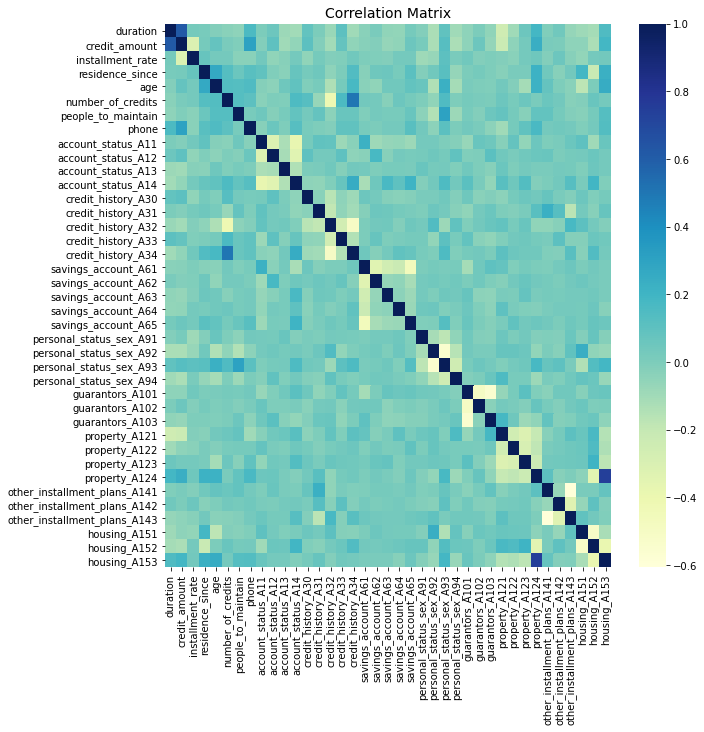

In [186]:
def plot_corr_matrix(df):
    # Sample figsize in inches
    fig, ax = plt.subplots(figsize=(10,10))         
    # Imbalanced DataFrame Correlation
    corr = df.corr()
    sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
    ax.set_title("Correlation Matrix", fontsize=14)
    plt.show()
    return

plot_corr_matrix(df_new_onehot)

# Other Classifier

In [187]:
def other_classifier(clf, X_train, y_train, X_test, y_test):
    y_pred = train_predict(clf, X_train, y_train, X_test, y_test)
    evaluate_test(y_test, y_pred)

    class_names = np.array([0, 1])
                           
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
        disp.ax_.set_title(title) 
        
        print(title)
        
        print(disp.confusion_matrix)

In [188]:
X_train, X_test, y_train, y_test = train_test_split(df_new_enc, label_onehot, test_size = 0.25)

Training a SVC
with a training set size of 1050
Test Precision Score: 0.7570621468926554
Test Recall Score: 0.7928994082840237
Test Accuracy Score: 0.7771428571428571
Test F1-score Score: 0.7745664739884395
Test Confusion Matrix: 
 [[138  43]
 [ 35 134]]
Number of False Positives: 43
Confusion matrix, without normalization
[[138  43]
 [ 35 134]]
Normalized confusion matrix
[[0.76243094 0.23756906]
 [0.20710059 0.79289941]]


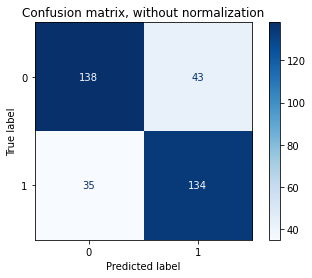

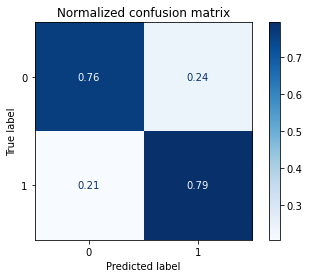

In [189]:
clf_svm = SVC(random_state = 9, kernel='linear')
other_classifier(clf_svm, X_train, y_train, X_test, y_test)

Training a LogisticRegression
with a training set size of 1050
Test Precision Score: 0.7058823529411765
Test Recall Score: 0.7810650887573964
Test Accuracy Score: 0.7371428571428571
Test F1-score Score: 0.7415730337078651
Test Confusion Matrix: 
 [[126  55]
 [ 37 132]]
Number of False Positives: 55
Confusion matrix, without normalization
[[126  55]
 [ 37 132]]
Normalized confusion matrix
[[0.6961326  0.3038674 ]
 [0.21893491 0.78106509]]


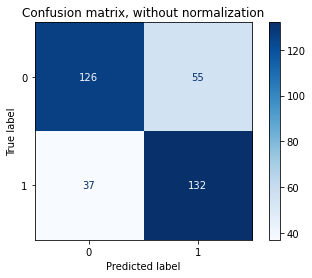

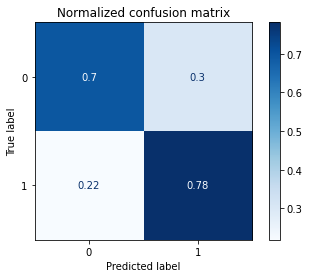

In [190]:
clf_log_reg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
other_classifier(clf_log_reg, X_train, y_train, X_test, y_test)

Training a DecisionTreeClassifier
with a training set size of 1050
Test Precision Score: 0.75
Test Recall Score: 0.8165680473372781
Test Accuracy Score: 0.78
Test F1-score Score: 0.781869688385269
Test Confusion Matrix: 
 [[135  46]
 [ 31 138]]
Number of False Positives: 46
Confusion matrix, without normalization
[[135  46]
 [ 31 138]]
Normalized confusion matrix
[[0.74585635 0.25414365]
 [0.18343195 0.81656805]]


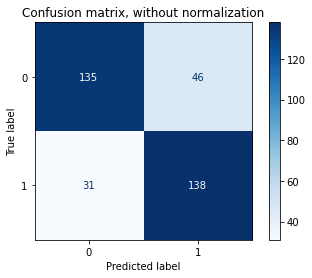

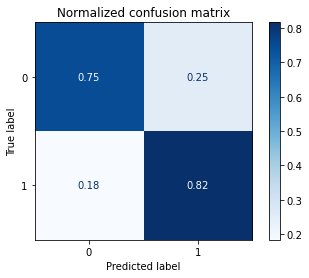

In [191]:
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_split=5, splitter = 'best', 
                                  min_samples_leaf = 25)
other_classifier(clf_tree, X_train, y_train, X_test, y_test)

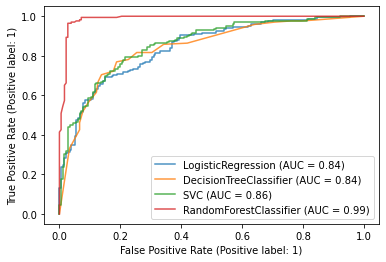

In [192]:
ax = plt.gca()

clf_log_reg_disp = plot_roc_curve(clf_log_reg, X_test, y_test, ax=ax, alpha=0.8)
clf_tree_disp = plot_roc_curve(clf_tree, X_test, y_test, ax=ax, alpha=0.8)
#clf_tree_disp.plot(ax=ax, alpha=0.8)
clf_svm_disp = plot_roc_curve(clf_svm, X_test, y_test, ax=ax, alpha=0.8)
clf_enc = plot_roc_curve(clf_enc, X_test, y_test, ax=ax, alpha=0.8)

plt.show()

In [193]:
# define the model
model = Sequential()

# hidden layer mit 16 inputs, 10 units
model.add(Dense(20, input_dim=16, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(20, activation = 'relu'))

# output layer
model.add(Dense(1, activation='sigmoid'))

# For a multi-class classification problem
history = model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'binary_crossentropy'])


model.fit(X_train, y_train, epochs=150, batch_size=5)

Epoch 1/150
210/210 [==============================] - 0s 1ms/step - loss: 6.2800 - accuracy: 0.5019 - binary_crossentropy: 6.2800
Epoch 2/150
210/210 [==============================] - 0s 1ms/step - loss: 2.8890 - accuracy: 0.5686 - binary_crossentropy: 2.8890
Epoch 3/150
210/210 [==============================] - 0s 1ms/step - loss: 3.7263 - accuracy: 0.5410 - binary_crossentropy: 3.7263
Epoch 4/150
210/210 [==============================] - 0s 1ms/step - loss: 1.9557 - accuracy: 0.5667 - binary_crossentropy: 1.9557
Epoch 5/150
210/210 [==============================] - 0s 1ms/step - loss: 3.0796 - accuracy: 0.5314 - binary_crossentropy: 3.0796
Epoch 6/150
210/210 [==============================] - 0s 1ms/step - loss: 3.2090 - accuracy: 0.5429 - binary_crossentropy: 3.2090
Epoch 7/150
210/210 [==============================] - 0s 1ms/step - loss: 2.1005 - accuracy: 0.5733 - binary_crossentropy: 2.1005
Epoch 8/150
210/210 [==============================] - 0s 1ms/step - loss: 2.0446 -

Epoch 125/150
210/210 [==============================] - 0s 1ms/step - loss: 0.5897 - accuracy: 0.6886 - binary_crossentropy: 0.5897
Epoch 126/150
210/210 [==============================] - 0s 1ms/step - loss: 0.6120 - accuracy: 0.6495 - binary_crossentropy: 0.6120
Epoch 127/150
210/210 [==============================] - 0s 1ms/step - loss: 0.6107 - accuracy: 0.6714 - binary_crossentropy: 0.6107
Epoch 128/150
210/210 [==============================] - 0s 1ms/step - loss: 0.6285 - accuracy: 0.6524 - binary_crossentropy: 0.6285
Epoch 129/150
210/210 [==============================] - 0s 1ms/step - loss: 0.6600 - accuracy: 0.5810 - binary_crossentropy: 0.6600
Epoch 130/150
210/210 [==============================] - 0s 2ms/step - loss: 0.6257 - accuracy: 0.6467 - binary_crossentropy: 0.6257
Epoch 131/150
210/210 [==============================] - 0s 1ms/step - loss: 0.6070 - accuracy: 0.6733 - binary_crossentropy: 0.6070
Epoch 132/150
210/210 [==============================] - 0s 1ms/step 

In [194]:
result = model.evaluate(X_train,y_train, verbose=0)
print(dict(zip(model.metrics_names, result)))

{'loss': 0.5371417999267578, 'accuracy': 0.7495238184928894, 'binary_crossentropy': 0.5371417999267578}


In [195]:
X_train, X_test, y_train, y_test = train_test_split(df_new_onehot, label_onehot, test_size = 0.25)

In [ ]:
clf_svm = SVC(random_state = 9, kernel='linear')
other_classifier(clf_svm, X_train, y_train, X_test, y_test)

Training a SVC
with a training set size of 1050


In [ ]:
clf_log_reg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
other_classifier(clf_log_reg, X_train, y_train, X_test, y_test)

In [ ]:
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_split=5, splitter = 'best', 
                                  min_samples_leaf = 25)
other_classifier(clf_tree, X_train, y_train, X_test, y_test)

In [ ]:
ax = plt.gca()

clf_log_reg_disp = plot_roc_curve(clf_log_reg, X_test, y_test, ax=ax, alpha=0.8)
clf_tree_disp = plot_roc_curve(clf_tree, X_test, y_test, ax=ax, alpha=0.8)
#clf_tree_disp.plot(ax=ax, alpha=0.8)
clf_svm_disp = plot_roc_curve(clf_svm, X_test, y_test, ax=ax, alpha=0.8)
clf_onehot = plot_roc_curve(clf_onehot, X_test, y_test, ax=ax, alpha=0.8)

plt.show()

In [100]:
# define the model
model = Sequential()

# hidden layer mit 39 inputs, 10 units
model.add(Dense(20, input_dim=39, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(20, activation = 'relu'))

# output layer
model.add(Dense(1, activation='sigmoid'))

# For a multi-class classification problem
history = model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'binary_crossentropy'])


model.fit(X_train, y_train, epochs=150, batch_size=5)

Epoch 1/150
210/210 [==============================] - 0s 2ms/step - loss: 3.4672 - accuracy: 0.4790 - binary_crossentropy: 3.4672
Epoch 2/150
210/210 [==============================] - 0s 2ms/step - loss: 3.1091 - accuracy: 0.5133 - binary_crossentropy: 3.1091
Epoch 3/150
210/210 [==============================] - 0s 2ms/step - loss: 2.3916 - accuracy: 0.5467 - binary_crossentropy: 2.3916
Epoch 4/150
210/210 [==============================] - 0s 2ms/step - loss: 2.5329 - accuracy: 0.5410 - binary_crossentropy: 2.5329
Epoch 5/150
210/210 [==============================] - 0s 2ms/step - loss: 4.2054 - accuracy: 0.5143 - binary_crossentropy: 4.2054
Epoch 6/150
210/210 [==============================] - 0s 2ms/step - loss: 3.0835 - accuracy: 0.5267 - binary_crossentropy: 3.0835
Epoch 7/150
210/210 [==============================] - 0s 2ms/step - loss: 1.4591 - accuracy: 0.5400 - binary_crossentropy: 1.4591
Epoch 8/150
210/210 [==============================] - 0s 2ms/step - loss: 2.1868 -

210/210 [==============================] - 0s 2ms/step - loss: 0.5215 - accuracy: 0.7590 - binary_crossentropy: 0.5215
Epoch 123/150
210/210 [==============================] - 1s 3ms/step - loss: 0.4876 - accuracy: 0.7762 - binary_crossentropy: 0.4876
Epoch 124/150
210/210 [==============================] - 1s 4ms/step - loss: 0.5157 - accuracy: 0.7686 - binary_crossentropy: 0.5157
Epoch 125/150
210/210 [==============================] - 0s 2ms/step - loss: 0.5726 - accuracy: 0.7219 - binary_crossentropy: 0.5726
Epoch 126/150
210/210 [==============================] - 0s 1ms/step - loss: 0.4976 - accuracy: 0.7762 - binary_crossentropy: 0.4976
Epoch 127/150
210/210 [==============================] - 0s 2ms/step - loss: 0.4898 - accuracy: 0.7743 - binary_crossentropy: 0.4898
Epoch 128/150
210/210 [==============================] - 0s 2ms/step - loss: 0.5100 - accuracy: 0.7676 - binary_crossentropy: 0.5100
Epoch 129/150
210/210 [==============================] - 0s 2ms/step - loss: 0.4938

In [101]:
result = model.evaluate(X_train,y_train, verbose=0)
print(dict(zip(model.metrics_names, result)))

{'loss': 0.5262203812599182, 'accuracy': 0.7552381157875061, 'binary_crossentropy': 0.5262203812599182}
